# Data Preparation

Since we are looking at contributing factors to a car crash, information that occurs after the crash event is not utilizable. 
So, we drop unncessary columns and transform the 'object' data types in the dataframe into a 'int' data type in order for us to pass it into a model.

For missing values, if there was a way to fill those in with a reasonable explaination, we did so. Luckily, missing values mostly fell under the columns which we determined not relevant to the crash.

First we dropped all unnecessary columns such as injury severity and street direction. After dropping missing values we could not reasonably populate ourselves, we were left with a dataset of ~950,000 entries. Then, we mapped all the object data types into an int or float 64 to pass into our model. Finally, we created a Target column to label the crashes as Preventable or Less Preventable.
***

Import packages

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Read the csv files using pandas

In [18]:
df_crash = pd.read_csv('../data/raw_data/Traffic_Crashes_Crashes.csv', low_memory=False)

In [19]:
df_vehicle = pd.read_csv('../data/raw_data/Traffic_Crashes_Vehicle.csv', low_memory=False)

In [20]:
df_people = pd.read_csv('../data/raw_data/Traffic_Crashes_People.csv', low_memory=False)

***
# Cleaning Crashes

### Dropping Columns


Within the Crashes dataset, our team determined that there were a lot of columns that did not contribute any value to the 
stakeholder's business problem, which is identifying causes of a car crash. Information such as injuries may tell us the severity of the crash, but not a clue on to how the crash occured. Same applies to when the police were notified and time it took place.

Columns such as 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I' may contain relevant information, however they hold too many null values for us to fill, so we decided to drop them.

Columns such 'STREET_DIRECTION' and 'ALIGNMENT' tells us the road shape, but since it is not feasible to change any of these roads - meaning they will always have turns and a direction - so we also left these columns from our final dataset.

In [21]:
# Drop columns that are not relevant to "Car Crash Contributors". For example, information about the injury severity does not 
# tell us a contributing factor to a crash.

not_relevant_info = ['RD_NO', 'CRASH_DATE', 'CRASH_DATE_EST_I', 'LANE_CNT', 'REPORT_TYPE', 'CRASH_TYPE', \
                     'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'DATE_POLICE_NOTIFIED', 'DAMAGE', 'NUM_UNITS', \
                     'HIT_AND_RUN_I', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'FIRST_CRASH_TYPE', \
                     'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'ALIGNMENT', \
                     'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', \
                     'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', \
                     'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', \
                     'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', \
                     'LOCATION', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'POSTED_SPEED_LIMIT']

df_crash.drop((not_relevant_info), axis = 1, inplace = True)


Define different functions to categorize columns into numarical columns for our models. 

In [22]:
# Helper Functions 
def traffic_control_transfomer(val):
    if val in relevant_device_present:
        return 1
    else:
        return 0
    
def device_working(val):
    if val in working_devices:
        return 1
    else:
        return 0

def device_present(val):
    if val == True:
        return 1
    else:
        return 0

def weather_condition(val):
    if val in bad_weather_cond:
        return 1
    else:
        return 0

def visibility(val):
    if val in bad_visibility:
        return 1
    else:
        return 0

def trafficway_danger(val):
    if val == 'NOT DIVIDED':
        return 1
    else:
        return 0

def road_cond(val):
    if val in bad_road_cond:
        return 1
    else:
        return 0

def defect_road(val):
    if val in road_defect:
        return 1
    else:
        return 0
    
def crash_cause(val):
    if val in driving:
        return 1
    elif val in behavior:
        return 2
    elif val in road:
        return 3
    else:
        return 4

def boolean(val):
    if val == False:
        return 0
    else:
        return 1
    
def one(val):
    if val == 5:
        return 1
    else:
        return val

def two(val):
    if val == 5:
        return 2
    else:
        return val

Initialize list to help map columns from object to int64 based upon the 4 main factors

In [23]:
relevant_device_present = ['TRAFFIC SIGNAL', 'STOP SIGN/FLASHER', 'OTHER', 'LANE USE MARKING', 'YIELD', 'OTHER REG. SIGN', \
                 'OTHER WARNING SIGN', 'RAILROAD CROSSING GATE', 'PEDESTRIAN CROSSING SIGN', 'POLICE/FLAGMAN', 'SCHOOL ZONE', \
                 'DELINEATORS', 'FLASHING CONTROL SIGNAL', 'BICYCLE CROSSING SIGN', 'NO PASSING', 'RR CROSSING SIGN']
working_devices = ['FUNCTIONING PROPERLY', 'WORN REFLECTIVE MATERIAL']
bad_weather_cond = ['RAIN', 'SNOW', 'FOG/SMOKE/HAZE', 'SLEET/HAIL', 'FREEZING RAIN/DRIZZLE', 'BLOWING SNOW', \
                   'SEVERE CROSS WIND GATE', 'BLOWING SAND, SOIL, DIRT']
bad_visibility = ['DARKNESS', 'DUSK', 'DAWN']
bad_road_cond = ['WET', 'SNOW OR SLUSH', 'ICE', 'SAND, MUD, DIRT']
road_defect = ['RUT, HOLES', 'WORN_SURFACE']

Map all columns to int64 to model

In [24]:
df_crash['BAD_WEATHER'] = df_crash['WEATHER_CONDITION'].map(weather_condition)
df_crash['BAD_VISIBILITY'] = df_crash['LIGHTING_CONDITION'].map(visibility)
df_crash['BAD_TRAFFIC'] = df_crash['TRAFFICWAY_TYPE'].map(trafficway_danger)
df_crash['BAD_ROAD_CONDITION'] = df_crash['ROADWAY_SURFACE_COND'].map(road_cond)
df_crash['DEFECT_ROAD'] = df_crash['ROAD_DEFECT'].map(defect_road)

df_crash['TRAFFIC_DEVICE_PRESENT'] = df_crash['TRAFFIC_CONTROL_DEVICE'].map(traffic_control_transfomer)
df_crash['DEVICE_WORKING'] = df_crash['DEVICE_CONDITION'].map(device_working)

Final 'Device' column that returns "1" when the traffice device is both present, AND working.

In [25]:
device_list = (df_crash['TRAFFIC_DEVICE_PRESENT'] == 1) & (df_crash['DEVICE_WORKING'] == 1)
device_dataframe = pd.DataFrame(device_list, columns = ['TRAFFIC_DEVICE'], index = df_crash.index)
frames = [df_crash, device_dataframe]
df_crash = pd.concat(frames, axis = 1)
df_crash['WORKING_TRAFFIC_DEVICE'] = df_crash['TRAFFIC_DEVICE'].map(device_present)

List for mapping "PRIMARY CONTRIBUTORY CAUSE" as recorded by officer at scene.

In [26]:
driving = ['FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY', 'IMPROPER OVERTAKING/PASSING', 'FAILING TO REDUCE SPEED TO AVOID CRASH', \
          'IMPROPER BACKING', 'IMPROPER LANE USAGE', 'IMPROPER TURNING/NO SIGNAL', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE', \
          'DISREGARDING TRAFFIC SIGNALS', 'DISREGARDING STOP SIGN', 'DISTRACTION - FROM INSIDE VEHICLE', 'DRIVING ON WRONG SIDE/WRONG WAY', \
          'DISTRACTION - FROM OUTSIDE VEHICLE', 'EXCEEDING AUTHORIZED SPEED LIMIT', 'EXCEEDING SAFE SPEED FOR CONDITIONS', \
          'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING ROAD MARKINGS', 'TURNING RIGHT ON RED', 'RELATED TO BUS STOP', 'DISREGARDING YIELD SIGN', \
           'PASSING STOPPED SCHOOL BUS']
behavior = ['PHYSICAL CONDITION OF DRIVER', 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER' \
           'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)', 'CELL PHONE USE OTHER THAN TEXTING', \
           'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)', 'TEXTING', 'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)']
road = ['WEATHER', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)', 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', \
       'ROAD CONSTRUCTION/MAINTENANCE']
other = ['EQUIPMENT - VEHICLE CONDITION', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST', 'ANIMAL', \
         'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 'OBSTRUCTED CROSSWALKS', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT']

df_crash['Target1'] = df_crash['PRIM_CONTRIBUTORY_CAUSE'].map(crash_cause)

Update any rows where 'PRIM_CONTRIBUTORY_CAUSE' is "not determined" and 'SEC_CONTRIBUTORY_CAUSE' have a value, then update 'PRIM_CONTRIBUTORY_CAUSE' to the value entered in'SEC_CONTRIBUTORY_CAUSE'

In [27]:
for index, row in df_crash.iterrows(): 
    if df_crash.loc[index,'PRIM_CONTRIBUTORY_CAUSE'] == 'UNABLE TO DETERMINE':
        if (df_crash.loc[index,'SEC_CONTRIBUTORY_CAUSE'] != 'UNABLE TO DETERMINE') & (df_crash.loc[index,'SEC_CONTRIBUTORY_CAUSE'] != 'NOT APPLICABLE'):
            df_crash.loc[index,'PRIM_CONTRIBUTORY_CAUSE'] = df_crash.loc[index,'SEC_CONTRIBUTORY_CAUSE']

Converting 'UNABLE TO DETERMINE' columns to be recorded as "road" when 'BAD ROAD CONDITION' is also true

In [28]:
df_crash['is_two'] = (df_crash['Target1'] == 4) & (df_crash['BAD_ROAD_CONDITION'] == 1)
df_crash['Target'] = df_crash['Target1'] + df_crash['is_two']
df_crash['is_two'] = df_crash['is_two'].map(two)
df_crash['Target'] = df_crash['Target1'] + df_crash['is_two']

In [29]:
def road(val):
    if val == 5:
        return 3
    else:
        return val
df_crash['Target'] = df_crash['Target'].map(road)

Drop transformed columns to have final clean dataset

In [30]:
unnecessary_traffic_columns = ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'TRAFFIC_DEVICE_PRESENT', 'DEVICE_WORKING', \
                              'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', \
                              'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'TRAFFIC_DEVICE', 'Target1', 'is_two']
df_crash.drop(unnecessary_traffic_columns, axis = 1, inplace = True)

Save file to a csv folder so we do not have to run all the data cleaning steps again.

In [31]:
df_crash.to_csv('../data/cleaned_data/cleaned_crash_data.csv')

***
# Cleaning People

Drop columns that do not have any predictive or inferential value in determining the cause of a car crash

In [32]:
df_people.drop(['PERSON_ID', 'PERSON_TYPE', 'RD_NO', 'VEHICLE_ID', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 
         'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 
         'INJURY_CLASSIFICATION', 'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 
         'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE', 'CELL_PHONE_USE'], axis=1, inplace=True)

Drop missing and null values

In [33]:
df_people.dropna(subset=['AGE'], inplace=True)
df_people.dropna(subset=['DRIVER_ACTION'], inplace=True)
df_people.dropna(subset=['DRIVER_VISION'], inplace=True)
df_people.dropna(subset=['PHYSICAL_CONDITION'], inplace=True)

Cleaning the 3 columns with many unknown values

In [34]:
df_people = df_people[df_people['DRIVER_VISION']!='UNKNOWN']
df_people = df_people[df_people['DRIVER_ACTION']!='UNKNOWN']
df_people = df_people[df_people['PHYSICAL_CONDITION']!='UNKNOWN']

Formatting, cleaning, and binning the AGE column. 15 is the youngest age to legally drive in the state of Illinois
with a learner's permit. 

In [35]:
df_people = df_people[df_people['AGE']>=15]

Define Lists for helper functions in order to map

In [36]:
dangerous_beh = ['IMPAIRED - ALCOHOL', 'FATIGUED/ASLEEP', 'EMOTIONAL', 'ILLNESS/FAINTED', 'HAD BEEN DRINKING', 
                 'IMPAIRED - DRUGS', 'IMPAIRED - ALCOHOL AND DRUGS', 'MEDICATED']
bad_vision = ['OTHER', 'MOVING VEHICLES', 'PARKED VEHICLES', 'WINDSHIELD (WATER/ICE)', 'BLINDED - SUNLIGHT', 'HILLCREST',
             'EMBANKMENT', 'BLOWING MATERIALS', 'SIGNBOARD']
bad_action = ['OTHER', 'FAILED TO YIELD', 'FOLLOWED TOO CLOSELY', 'IMPROPER TURN', 'IMPROPER BACKING', 'IMPROPER LANE CHANGE',
             'IMPROPER PASSING', 'TOO FAST FOR CONDITIONS', 'DISREGARDED CONTROL DEVICES', 'IMPROPER PARKING',
             'WRONG WAY/SIDE', 'CELL PHONE USE OTHER THAN TEXTING', 'OVERCORRECTED', 'EMERGENCY VEHICLE ON CALL',
             'EVADING POLICE VEHICLE', 'TEXTING', 'STOPPED SCHOOL BUS', 'LICENSE RESTRICTIONS']

Transform more categorical columns into numerical format. 

In [37]:
def physical_condition(val):
    if val in dangerous_beh:
        return 1
    else:
        return 0
    
def obscured_vision(val):
    if val in bad_vision:
        return 1
    else:
        return 0

def driver_error(val):
    if val in bad_action:
        return 1
    else:
        return 0

def ages(val):
    if val in highrisk_ages:
        return 1
    else:
        return 0

Map and drop object columns as they were tranformed into a data format we can pass into a model columns

In [38]:
df_people['DANGEROUS_BEH'] = df_people['PHYSICAL_CONDITION'].map(physical_condition)
df_people['OBSCURED_VIZ'] = df_people['DRIVER_VISION'].map(obscured_vision)
df_people['DRIVER_ERROR'] = df_people['DRIVER_ACTION'].map(driver_error)
unnecessary_columns = ['AGE', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION']
df_people.drop(unnecessary_columns, axis = 1, inplace=True)

Save file to a csv folder so we do not have to run all the data cleaning steps again.

In [39]:
df_people.to_csv('../data/cleaned_data/cleaned_people_data.csv')

***
# Cleaning Vehicles

Instantiate pandas DataFrame with only relevant columns

In [40]:
df_vehicle = df_vehicle[['CRASH_RECORD_ID', 'NUM_PASSENGERS', 'VEHICLE_DEFECT']]

Transform the last categorical columns into numerical format and clean up for our models. 

In [49]:
No_def = ['NONE', 'UNKNOWN']

def veh_defect(val):
    if val in No_def:
        return 0
    else:
        return 1

def passengers(val):
    if val >= 1:
        return 1
    else:
        pass

In [42]:
df_vehicle['VEHICLE_DEFECT'] = df_vehicle['VEHICLE_DEFECT'].map(veh_defect)
df_vehicle['NUM_PASSENGERS'] = df_vehicle['NUM_PASSENGERS'].map(passengers)

If missing values for passengers, update to just driver in car

In [43]:
df_vehicle.NUM_PASSENGERS = df_vehicle.NUM_PASSENGERS.fillna(0)

Save file to a csv folder so we do not have to run all the data cleaning steps again.

In [44]:
df_vehicle.to_csv('../data/cleaned_data/cleaned_vehicle_data.csv')

# Creating the Main Dataframe, "main_df"

In [45]:
# Merge the the DataFrames into one using 'CRASH_RECORD_ID' column to join
main_df = df_crash.merge(df_vehicle, left_on='CRASH_RECORD_ID', right_on = 'CRASH_RECORD_ID', how='inner')
main_df = main_df.merge(df_people, left_on='CRASH_RECORD_ID', right_on = 'CRASH_RECORD_ID', how='inner')

Once we merged the dataframes, we noticed that the number of rows in our dataset increased drastically, but not exactly 2x. 

After examining the data, we found that some rows had split into two entries due to a crash normally involving two parties (but not always, so hence the ALMOST 2x). 

We decided to keep the duplicated entries as no matter how many parties were involved, a cause that determined the crash affected all parties.

Then, we fixed the Target columns to accurately reflect the 'DANGEROUS_BEH' column as the Target column was created before the 
'DANGEROUS_BEH' merge. Same logic applies to the 'DRIVER_ERROR' column.

In [46]:
# Converting 'UNABLE TO DETERMINE' columns to be recorded as "behavior" when 'DANGEROUS_BEH' is also true
main_df['is_two'] = (main_df['Target'] == 4) & (main_df['DANGEROUS_BEH'] == 1)
main_df['is_two'] = main_df['is_two'].map(boolean)
main_df['Target'] = main_df['Target'] + main_df['is_two']
main_df['Target'] = main_df['Target'].map(two)
main_df.drop(['is_two'], axis = 1, inplace = True)

# Converting 'UNABLE TO DETERMINE' columns to be recorded as "driver" when 'DRIVER_ERROR' is also true
main_df['is_one'] = (main_df['Target'] == 4) & (main_df['DRIVER_ERROR'] == 1)
main_df['is_one'] = main_df['is_one'].map(boolean)
main_df['Target'] = main_df['Target'] + main_df['is_one']
main_df['Target'] = main_df['Target'].map(one)
main_df.drop(['is_one'], axis = 1, inplace = True)

## Originally we wanted to do a 4 target classifer - driver error, behavioral error, road conditions, and other factors.

However, due to the class imbalance, we grouped driver action (driver error, behavioral error) and road / external factors in order to fix the class imbalance problem.

In [47]:
def target_map(val):
    if ((val == 1) | (val == 2)):
        return 0
    elif ((val == 3) | (val == 4)):
        return 1
    
main_df['Target'] = main_df['Target'].map(target_map)
main_df['Target'].value_counts()



0    718270
1    233870
Name: Target, dtype: int64

Before saving our final modeling data to a csv, we ran a heatmap to see if there are any concerning correlations.

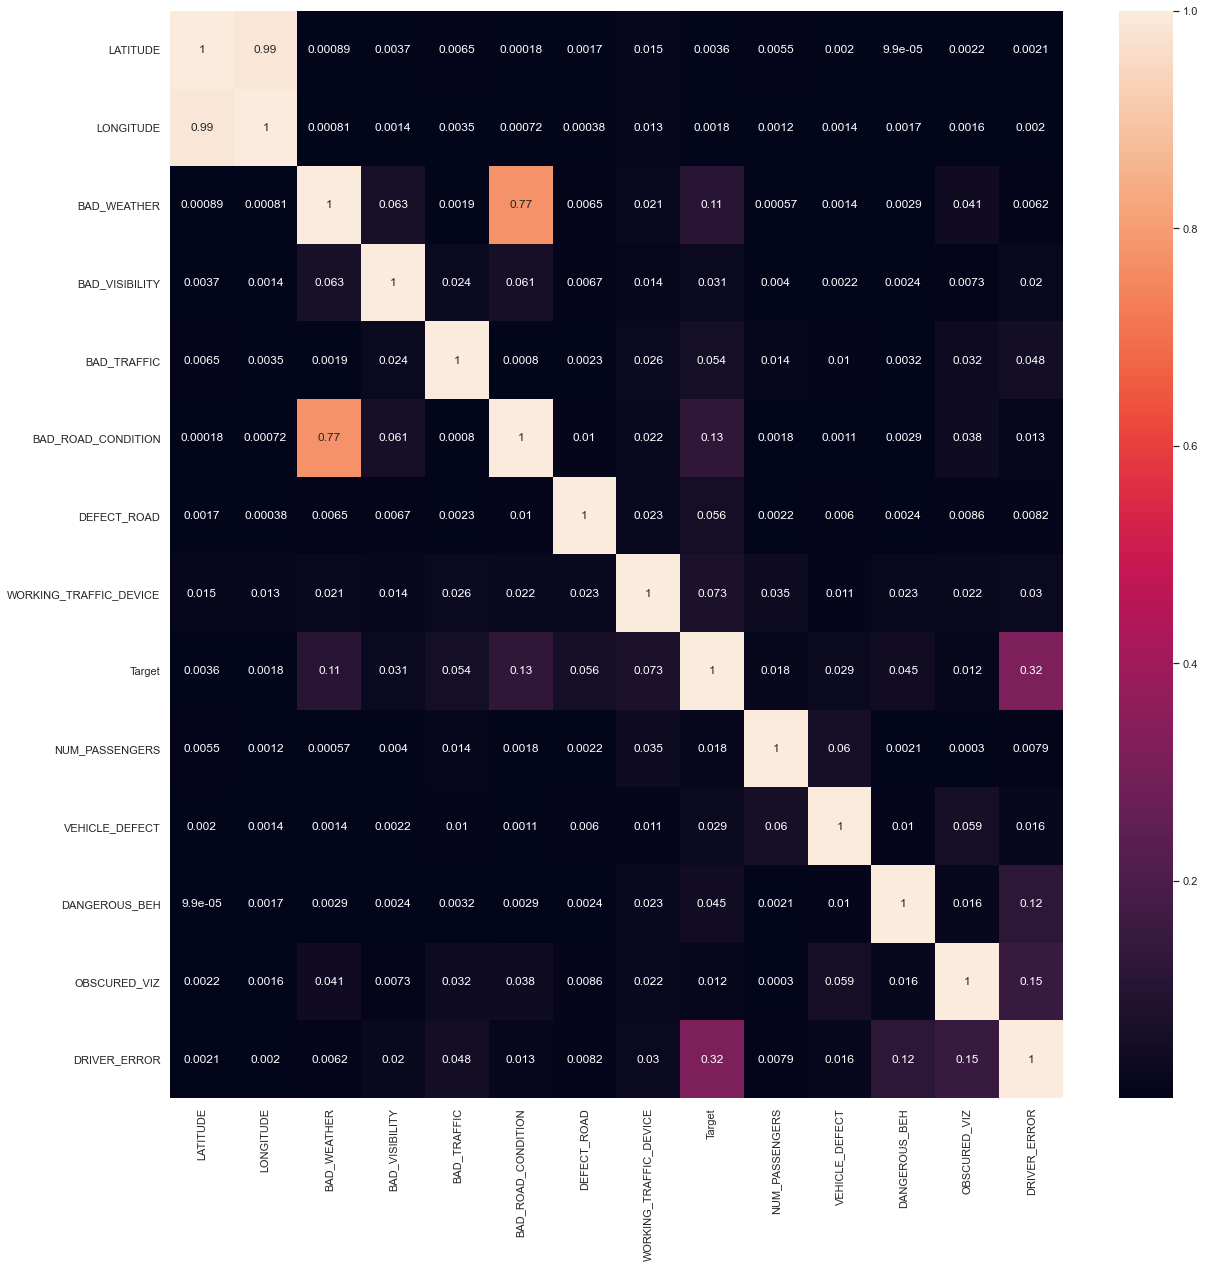

In [48]:
sns.set(rc={'figure.figsize':(20, 20)})
sns.heatmap(main_df.corr().abs(),annot=True);

Because BAD_WEATHER and BAD_ROAD_CONDITIONS are highly correlated with each other. To not overfit to our data, we dropped BAD_WEATHER from our dataset.

In [39]:
main_df.drop('BAD_WEATHER', axis = 1, inplace = True)

Save final file to a csv folder for our main cleaned csv file. 

In [40]:
main_df.to_csv('../data/cleaned_data/cleaned_modeling_data.csv')

In [51]:
# A preview, if you wanted to load the data to explore
main_df = pd.read_csv('../data/cleaned_data/cleaned_modeling_data.csv')
main_df.drop('Unnamed: 0', axis = 1, inplace = True)
main_df.head()

,CRASH_RECORD_ID,LATITUDE,LONGITUDE,BAD_VISIBILITY,BAD_TRAFFIC,BAD_ROAD_CONDITION,DEFECT_ROAD,WORKING_TRAFFIC_DEVICE,Target,NUM_PASSENGERS,VEHICLE_DEFECT,CRASH_DATE,DANGEROUS_BEH,OBSCURED_VIZ,DRIVER_ERROR
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,41.919664,-87.773288,0,0,0,0,0,0,0.0,0,07/10/2019 05:56:00 PM,0,0,0
1,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,41.919664,-87.773288,0,0,0,0,0,0,1.0,0,07/10/2019 05:56:00 PM,0,0,0
2,009e9e67203442370272e1a13d6ee51a4155dac65e583d...,41.741804,-87.740954,0,1,0,0,1,0,0.0,0,06/30/2017 04:00:00 PM,0,0,0
3,009e9e67203442370272e1a13d6ee51a4155dac65e583d...,41.741804,-87.740954,0,1,0,0,1,0,1.0,0,06/30/2017 04:00:00 PM,0,0,0
4,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,41.773456,-87.585022,0,0,0,0,1,0,0.0,0,07/10/2020 10:25:00 AM,0,0,1
